In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

!pip3 install huggingface-hub
from huggingface_hub import hf_hub_download
import joblib
%matplotlib inline

In [5]:
global_df = pd.read_csv('water_potab.csv', sep=',')

# работаем с копией данных
wdf = global_df.copy()

In [6]:
display(wdf.head(2))
display(wdf.tail(2))

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.71608,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
9826,5.126763,230.603758,11983.86938,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1
9827,7.874671,195.102299,17404.17706,7.509306,NaN,327.459761,16.140368,78.698446,2.309149,1


In [7]:
wdf.info()
wdf.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9828 entries, 0 to 9827
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               8353 non-null   float64
 1   Hardness         9828 non-null   float64
 2   Solids           9828 non-null   float64
 3   Chloramines      9828 non-null   float64
 4   Sulfate          7485 non-null   float64
 5   Conductivity     9828 non-null   float64
 6   Organic_carbon   9828 non-null   float64
 7   Trihalomethanes  9342 non-null   float64
 8   Turbidity        9828 non-null   float64
 9   Potability       9828 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 767.9 KB


,0
ph,1475
Hardness,0
Solids,0
Chloramines,0
Sulfate,2343
Conductivity,0
Organic_carbon,0
Trihalomethanes,486
Turbidity,0
Potability,0


In [8]:
wdf.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,8353.000000,9828.000000,9828.000000,9828.000000,7485.000000,9828.000000,9828.000000,9342.000000,9828.000000,9828.00000
mean,7.081075,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.39011
std,1.593855,32.876415,8767.678489,1.582924,41.411306,80.815839,3.307825,16.173277,0.780303,0.48780
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.00000
25%,6.093092,176.850538,15666.690300,6.127421,307.694522,365.734414,12.065801,55.835966,3.439711,0.00000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.00000
75%,8.062066,216.667456,27332.762125,8.114887,359.951766,481.792305,16.557652,77.339918,4.500320,1.00000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.00000


In [9]:
print(wdf.nunique())

ph                 2785
Hardness           3276
Solids             3276
Chloramines        3276
Sulfate            2495
Conductivity       3276
Organic_carbon     3276
Trihalomethanes    3114
Turbidity          3276
Potability            2
dtype: int64


# Преобразование данных

Исходя из анализа данных в данных довольно много пропусков



In [10]:
cols_null_percent = wdf.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

,0
Sulfate,23.840049
ph,15.008140
Trihalomethanes,4.945055


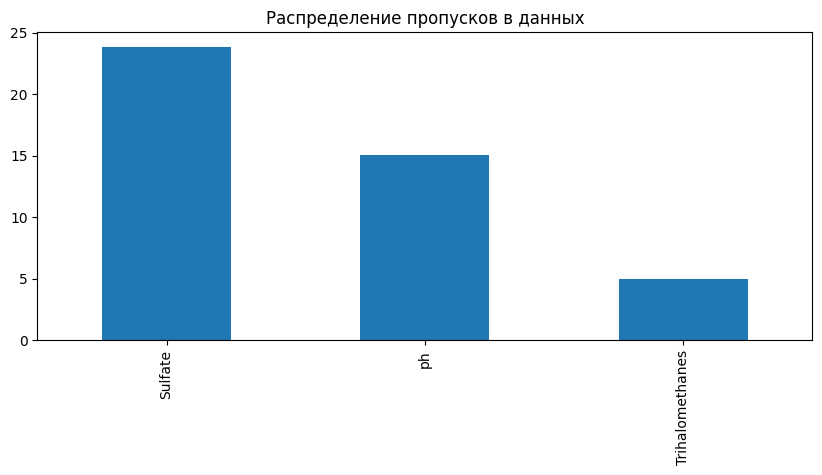

In [11]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);


Перед измененим данных посомрим на распределение в графах с 0

array([[<Axes: title={'center': 'Sulfate'}>,
        <Axes: title={'center': 'ph'}>],
       [<Axes: title={'center': 'Trihalomethanes'}>, <Axes: >]],
      dtype=object)

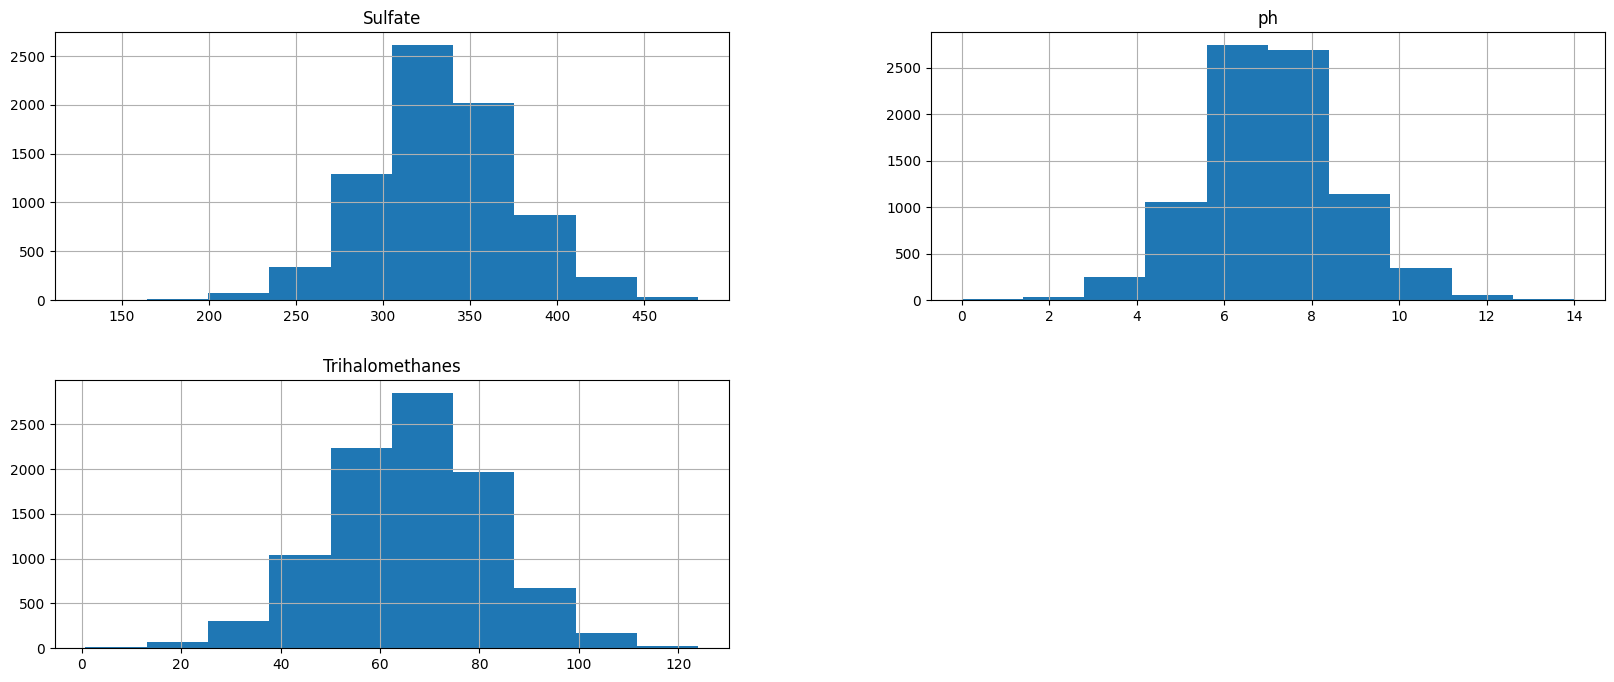

In [12]:
wdf[cols_with_null.index].hist(figsize=(20, 8))

Процены пропусков менее 30% + распределение похоже на нормальное -> оставляем столбцы и замеяем на среднее  медиану

In [13]:
wdf_1 = wdf.copy()

#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'Sulfate': wdf_1['Sulfate'].median(),
    'ph': wdf_1['ph'].median(),
    'Trihalomethanes': wdf_1['Trihalomethanes'].median(),
}

#заполняем пропуски в соответствии с заявленным словарем
wdf_1 = wdf_1.fillna(values)
#выводим результирующую долю пропусков
wdf_1.isnull().mean()

,0
ph,0.0
Hardness,0.0
Solids,0.0
Chloramines,0.0
Sulfate,0.0
Conductivity,0.0
Organic_carbon,0.0
Trihalomethanes,0.0
Turbidity,0.0
Potability,0.0


строим графки после замены

array([[<Axes: title={'center': 'Sulfate'}>,
        <Axes: title={'center': 'ph'}>],
       [<Axes: title={'center': 'Trihalomethanes'}>, <Axes: >]],
      dtype=object)

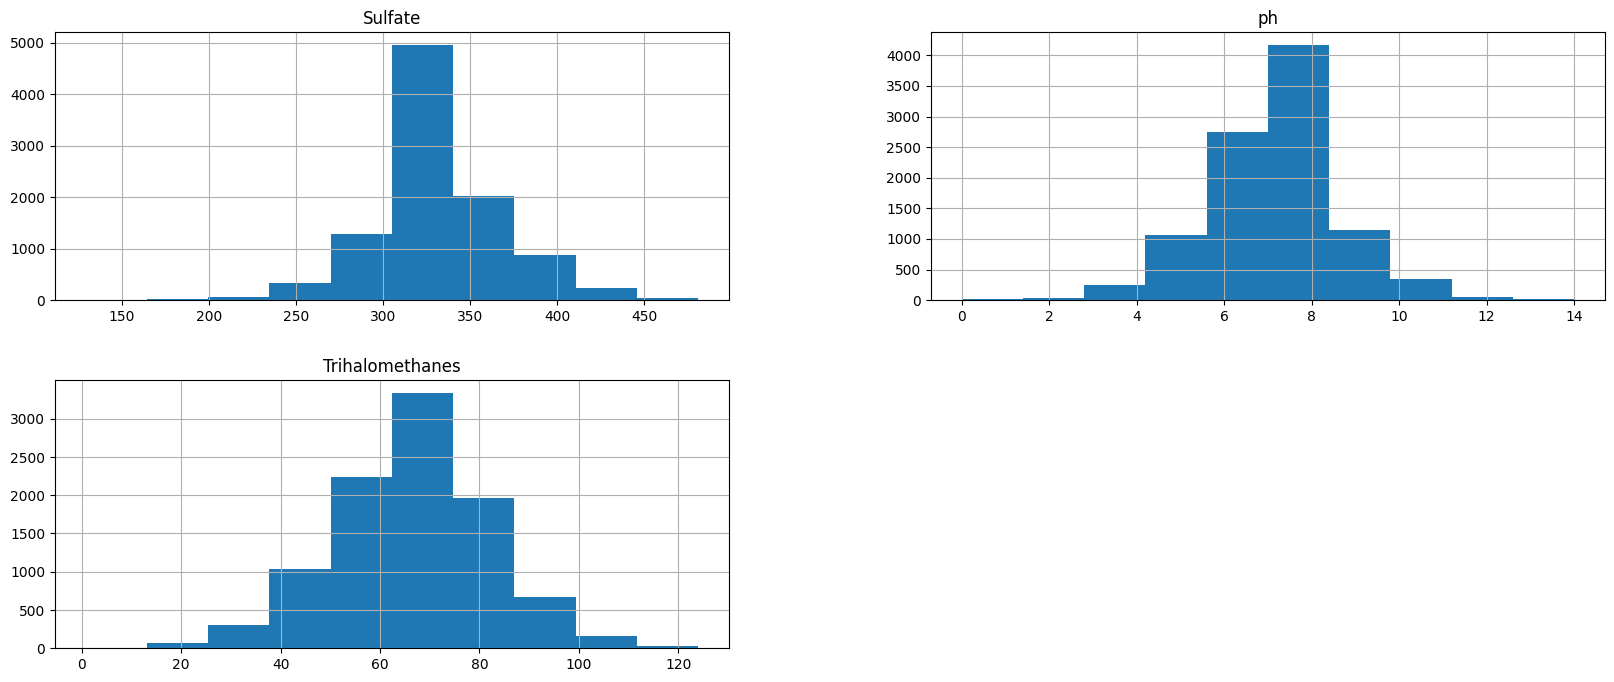

In [14]:
wdf_1[cols_with_null.index].hist(figsize=(20, 8))

Проверим выбросы

,0
ph,"Axes(0.125,0.53;0.133621x0.35)"
Hardness,"Axes(0.285345,0.53;0.133621x0.35)"
Solids,"Axes(0.44569,0.53;0.133621x0.35)"
Chloramines,"Axes(0.606034,0.53;0.133621x0.35)"
Sulfate,"Axes(0.766379,0.53;0.133621x0.35)"
Conductivity,"Axes(0.125,0.11;0.133621x0.35)"
Organic_carbon,"Axes(0.285345,0.11;0.133621x0.35)"
Trihalomethanes,"Axes(0.44569,0.11;0.133621x0.35)"
Turbidity,"Axes(0.606034,0.11;0.133621x0.35)"
Potability,"Axes(0.766379,0.11;0.133621x0.35)"


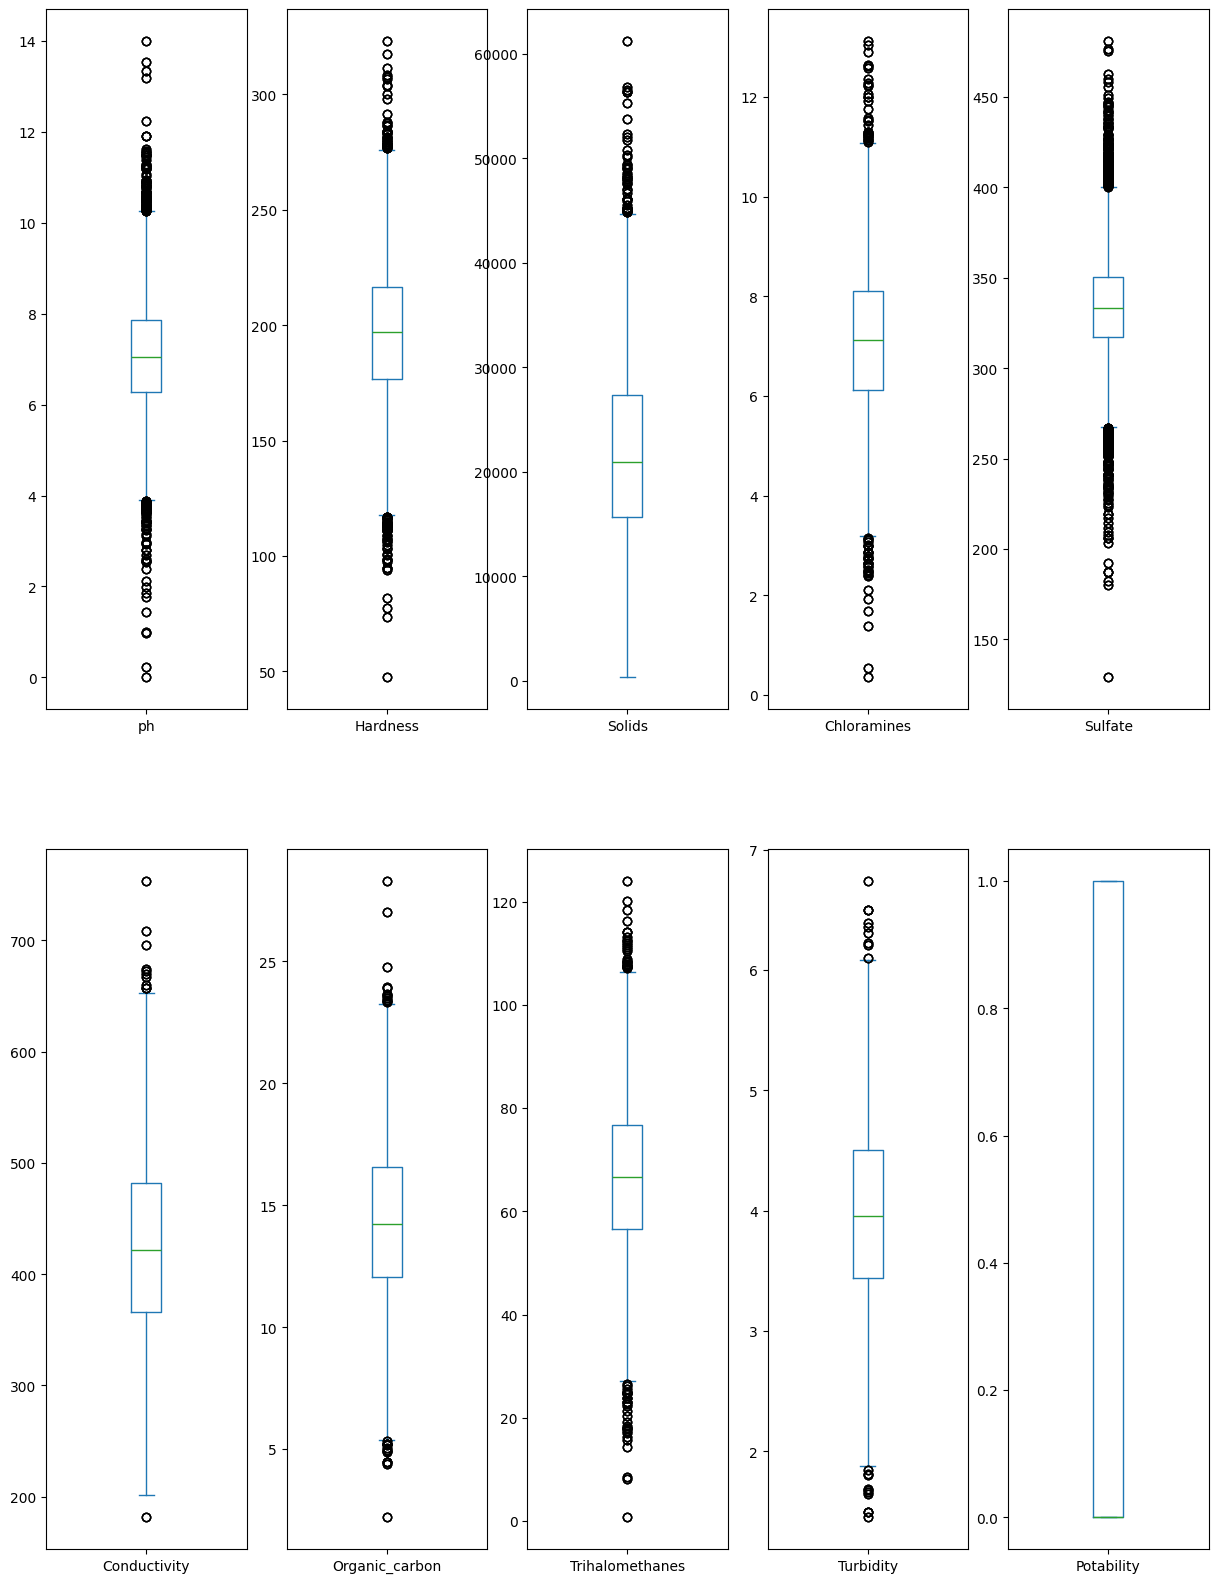

In [15]:
wdf_1.plot(kind='box', subplots=True, layout=(2, 5), figsize=(15, 20), sharex=False, sharey=False)

<Axes: ylabel='Frequency'>

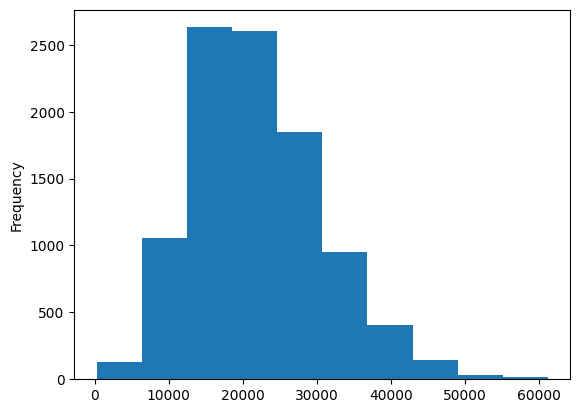

In [16]:
wdf_1.Solids.plot(kind='hist')

In [17]:
wdf_2 = wdf_1.copy()
dbscan = DBSCAN(eps=500)
wdf_2['Solids_dbscan_pred_1'] = dbscan.fit_predict(wdf_2['Solids'].values.reshape(-1, 1))
wdf_2[wdf_2.Solids_dbscan_pred_1 < 0]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Solids_dbscan_pred_1
1068,3.344589,156.479927,55334.70280,8.530102,371.147770,485.631148,16.980610,69.622490,2.575141,0,-1
2602,7.036752,159.399398,61227.19601,3.713594,312.976254,377.067972,17.246698,82.197233,3.860807,0,-1
3130,8.140344,153.748170,50793.89892,7.843498,306.218950,423.455906,14.322019,65.076610,4.362792,1,-1
3162,9.079715,222.042631,53735.89919,6.894915,254.040977,382.896166,12.704887,101.615346,4.551724,1,-1
4344,3.344589,156.479927,55334.70280,8.530102,371.147770,485.631148,16.980610,69.622490,2.575141,0,-1
5878,7.036752,159.399398,61227.19601,3.713594,312.976254,377.067972,17.246698,82.197233,3.860807,0,-1
6406,8.140344,153.748170,50793.89892,7.843498,306.218950,423.455906,14.322019,65.076610,4.362792,1,-1
6438,9.079715,222.042631,53735.89919,6.894915,254.040977,382.896166,12.704887,101.615346,4.551724,1,-1
7620,3.344589,156.479927,55334.70280,8.530102,371.147770,485.631148,16.980610,69.622490,2.575141,0,-1
9154,7.036752,159.399398,61227.19601,3.713594,312.976254,377.067972,17.246698,82.197233,3.860807,0,-1


# Исследование зависимостей

In [18]:
#список неинформативных признаков

wdf_5 = wdf_1.copy()

low_information_cols = []

#цикл по всем столбцам
for col in wdf_5.columns:
    #наибольшая относительная частота в признаке
    top_freq = wdf_5[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = wdf_5[col].nunique() / wdf_5[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

if not low_information_cols:
    print(f'Неинформативных столбцов не найдено')

Неинформативных столбцов не найдено


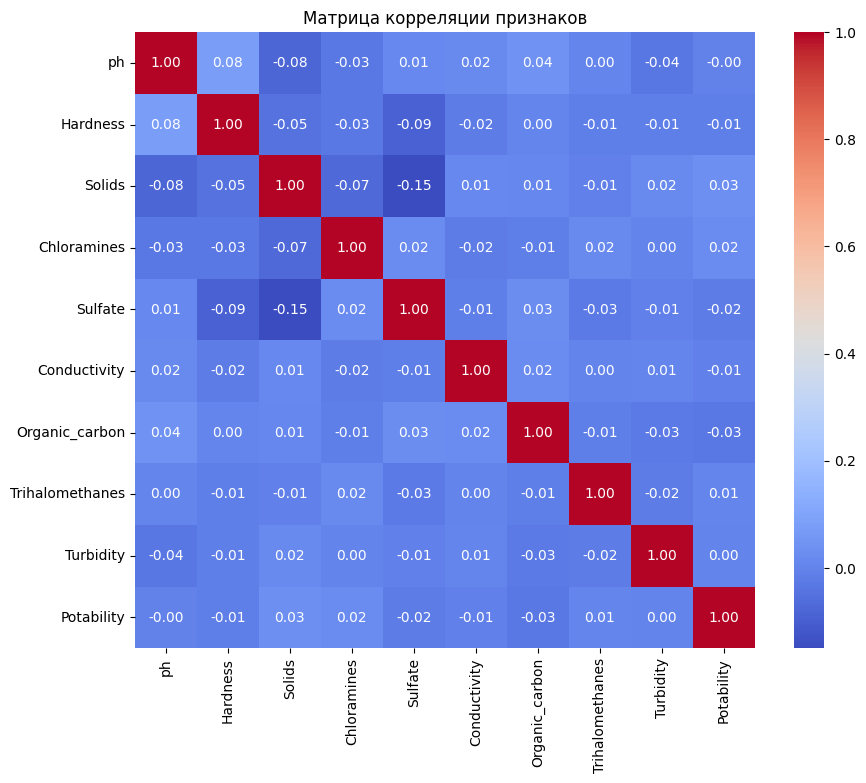


Корреляция с признаком  Пригодность для питья (Potability):
Potability         1.000000
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.006887
Turbidity          0.001581
ph                -0.003140
Conductivity      -0.008128
Hardness          -0.013837
Sulfate           -0.020476
Organic_carbon    -0.030001
Name: Potability, dtype: float64


In [19]:
# Матрица корреляции
plt.figure(figsize=(10, 8))
# 'Outcome' - целевой признак (0/1)
correlation_matrix = wdf_5.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции признаков')
plt.show()

# Вывод корреляции с целевым признаком
print("\nКорреляция с признаком  Пригодность для питья (Potability):")
print(correlation_matrix['Potability'].sort_values(ascending=False))

Корреляции между признаками не найдено

In [20]:
wdf_fin = wdf_5.copy()

# Тестирование модели

In [21]:
# Download and load the trained pipeline
pipeline_path = hf_hub_download("DarkNeuron-AI/darkneuron-hydrasense-v1", "water_potability_model.pkl")
model = joblib.load(pipeline_path)
# Example water sample

sample_df = wdf_fin.copy()
sample_df.drop(['Potability'], axis=1, inplace=True)

y0 = wdf_fin['Potability']


# Predict potability
prediction = model.predict(sample_df)

#print("Prediction:", "💧 Potable" if prediction[0] == 1 else "⚠️ Not Potable")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


water_potability_model.pkl:   0%|          | 0.00/7.34M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.2 when using version 1.6.1. This might lead to b

In [22]:
# Расчет Accuracy
accuracy = accuracy_score(y0, prediction)
print(f"Точность (Accuracy): {accuracy:.2f}")

Точность (Accuracy): 0.93


In [23]:
print(classification_report(y0, prediction))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5994
           1       0.95      0.88      0.91      3834

    accuracy                           0.93      9828
   macro avg       0.94      0.93      0.93      9828
weighted avg       0.94      0.93      0.93      9828



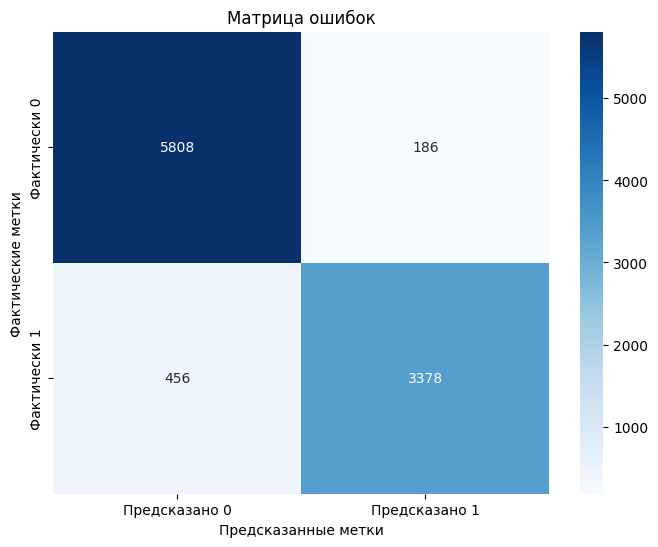

In [24]:
conf_matrix = confusion_matrix(y0, prediction)

# Визуализация с использованием Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Фактически 0', 'Фактически 1'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Фактические метки')
plt.title('Матрица ошибок')
plt.show()